# Συμπίεση εικόνων με χρήση DCT

In [6]:
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap='gray',vmin=vmin, vmax=vmax)
        ax.set_title(label)

# Βήματα κωδικοποίησης, συμπίεσης και αποκωδικοποίησης εικόνας

Θα δημιουργήσουμε συναρτήσεις για τη υλοποίηση της α) κωδικοποίησης, β) συμπίεσης και γ) αποκωδικοποίησης της εικόνας (Κατεβάστε την εικόνα από [εδώ](https://drive.google.com/file/d/1EzljukzZIIrRO4KeqVI-MFDrhQbjJvvN/view?usp=sharing).



#### Ορισμός συνάρτησης απεικόνισης πολλαπλών εικόνων

In [7]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import scipy
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2
from scipy.fftpack import dct, idct

from skimage import io,color,img_as_float,img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from numpy import r_
import cv2
#from skimage.draw import line, polygon, circle, ellipse
from PIL import Image 
import math

## Βήμα 1: Κωδικοποίηση εικόνας




### α) Διάβασμα εικόνας και μετατροπή στο χρωματικό χώρο YCbCr

In [8]:
# Read flowers.tif
image=io.imread('flowers.tif')
h=image.shape[0]
w=image.shape[1]
d=image.shape[2]

In [9]:
#RGBtoYCbCrChannel(image)
#input RGB image -> outup Y, Cb, Cr channel , 
#Y:Luminance  Cr = R – Y ( how far is the red component from Luminance)
#Cb = B – Y ( how far is the blue component from Luma ).

def RGBtoYCbCrChannel(image):
   RGB_image = img_as_float(image)
   YCbCr_image =color.rgb2ycbcr(RGB_image)
   YCbCr_image = YCbCr_image.astype(np.uint8)
   #print("type, min, max:", RGB_image.dtype, RGB_image.min(), RGB_image.max())
   print("type, min, max:", YCbCr_image.dtype, YCbCr_image.min(), YCbCr_image.max())
   #YCbCr_image.shape
   Y_channel=img_as_float(YCbCr_image[:,:,0])
   Cb_channel=img_as_float(YCbCr_image[:,:,1])
   Cr_channel=img_as_float(YCbCr_image[:,:,2])

   f, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(20, 15))
   ax0.imshow(RGB_image)
   ax0.set_title('RGB', fontsize=12)
   ax1.imshow(YCbCr_image)
   ax1.set_title('YCbCr', fontsize=12)
   ax2.imshow(Y_channel)
   ax2.set_title('Y channel', fontsize=12)
   ax3.imshow(Cb_channel)
   ax3.set_title('Cb channel', fontsize=12)
   ax4.imshow(Cr_channel)
   ax4.set_title('Cr channel', fontsize=12)
     
   return Y_channel,Cb_channel,Cr_channel

type, min, max: uint8 16 235


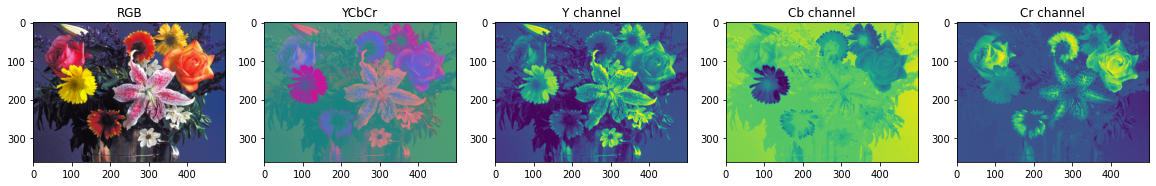

In [10]:
Y_channel,Cb_channel,Cr_channel=RGBtoYCbCrChannel(image)

### β) Χρήση μετασχηματισμού συχνότητας σε ολόκληρη την εικόνα και σε μη επικαλυπτόμενα blocks 8x8 (DCT) 

In [11]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')


def dct2block(a):
  imsize = a.shape
  im_dct = np.zeros(imsize)
  # Do 8x8 DCT on image (in-place)
  for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        im_dct[i:(i+8),j:(j+8)] = dct2( a[i:(i+8),j:(j+8)])
  return im_dct


def idct2block(a):
  imsize = a.shape
  im_idct = np.zeros(imsize)
  # Do 8x8 DCT on image (in-place)
  for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        im_idct[i:(i+8),j:(j+8)] = idct2(a[i:(i+8),j:(j+8)])
  return im_idct

In [12]:
#DCT transform
Y_dct=dct2(Y_channel)
Cb_dct=dct2(Cb_channel)
Cr_dct=dct2(Cr_channel)

#DCT 8x8 block
Y_dct_blk=dct2block(Y_channel)
Cb_dct_blk=dct2block(Cb_channel)
Cr_dct_blk=dct2block(Cr_channel)


## Βήμα 2: Συμπίεση εικόνας
### Χρήση κατάλληλης μάσκας για αποκοπή λιγότερων σημαντικών συχνοτήτων

####Μάσκα για αποκοπή λιγότερων σημαντικών στοιχείων του DCT (σε ολόκληρη την εικόνα ή σε block αυτής)

In [13]:
# Δημιουργία άνω τριγωνικής μάσκας για το DCT και για το DCT 8x8 μη επικαλυπτόμενα blocks
#Channel: Εικόνα εισόδου
#n: πλήθος των διαγωνίων πάνω (diag<0) και κάτω (diag>0) από την αντιδιαγώνιος(Δευτερεύουσα) (diag= 0) που ξεκινά από την επάνω δεξιά γωνία και συνεχίζει διαγώνια ως την κάτω αριστερή γωνία 
def create_upper_triangular_mask(Channel,n):
  r=Channel.shape[0]
  c=Channel.shape[1]
  diag=c-n
  mask=np.fliplr(np.triu(np.ones((r,c)),diag))
  return mask  

Μάσκες για αποκοπή λιγότερων σημαντικών στοιχείων των DCT blocks

####Μάσκα Zig-zag
![zig zag](https://drive.google.com/uc?id=1P-etco2j9JWVNKf6QOCZ3EM20L8s-yp_)
![zig zag](https://drive.google.com/uc?id=1fj0PWtU-tKHUjDfd8bIgwuz6uaa9yBPk)



![zig](https://drive.google.com/uc?id=1P-etco2j9JWVNKf6QOCZ3EM20L8s-yp_)

https://drive.google.com/file/d/1fj0PWtU-tKHUjDfd8bIgwuz6uaa9yBPk/view?usp=sharing 

In [14]:
# Δημιουργία zigzag μάσκας για block 8x8
# n: το τελικό στοιχείο που θα κρατηθεί από το zig-zag array
def zigzag(n):
  z = np.array([[1,2,6,7,15,16,28,29],[3, 5,8,14,17,27,30,43],[4, 9,13,18,26,31,42,44],[10,12,19,25,32,41,45,54],[11,20,24,33,40,46,53,55],[21,23,34,39,47,52,56,61],[22,35,38,48,51,57,60,62],[36,37,49,50,58,59,63,64]])
  z[z > n] = 0;
  return z

#### Μάσκες κατά JPEG
> ![Σχήμα 2](https://drive.google.com/uc?id=10_yJaw1U6QBhr8m06KPmGIt4fk9jfDUd)

In [15]:
#-------------------------------------------------------------------------------------------
# Δημιουργία μασκών για κβάντιση 
# q:  Quality 

def mask_quant_Y(q):
  maskfY =np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]])
  QmaskY = q * maskfY;  
  return QmaskY

# Κανάλι Cb και Cr
def mask_quant_C(q):
  maskfC = np.array([[17,18,24,47,99,99,99,99],[18,21,26,66,99,99,99,99],[24,26,56,99,99,99,99,99],[47,66,99,99,99,99,99,99],[99,99,99,99,99,99,99,99],[99,99,99,99,99,99,99,99],[99,99,99,99,99,99,99,99],[99,99,99,99,99,99,99,99]])
  QmaskC = q * maskfC;  
  return QmaskC

### Εφαρμογή μασκών

#### α) Εφαρμογή μάσκας για αποκοπή λιγότερων σημαντικών στοιχείων του DCT σε ολόκληρη την εικόνα

In [16]:
maskYdct=create_upper_triangular_mask(Y_channel,200)
Y_dct_mask=Y_dct*maskYdct

maskCbdct=create_upper_triangular_mask(Cb_channel,100)
Cb_dct_mask=Cb_dct*maskCbdct

maskCrdct=create_upper_triangular_mask(Cr_channel,100)
Cr_dct_mask=Cr_dct*maskCrdct


<ipython-input-17-867e6cddda24>:6: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow((np.log10( Y_dct_mask)).astype(int), cmap=pylab.cm.gray)
<ipython-input-17-867e6cddda24>:6: RuntimeWarning: invalid value encountered in log10
  ax1.imshow((np.log10( Y_dct_mask)).astype(int), cmap=pylab.cm.gray)
<ipython-input-17-867e6cddda24>:12: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow((np.log10(Cb_dct_mask)).astype(int), cmap=pylab.cm.gray)
<ipython-input-17-867e6cddda24>:12: RuntimeWarning: invalid value encountered in log10
  ax3.imshow((np.log10(Cb_dct_mask)).astype(int), cmap=pylab.cm.gray)


Text(0.5, 1.0, 'Cb Channel after applying dct mask')

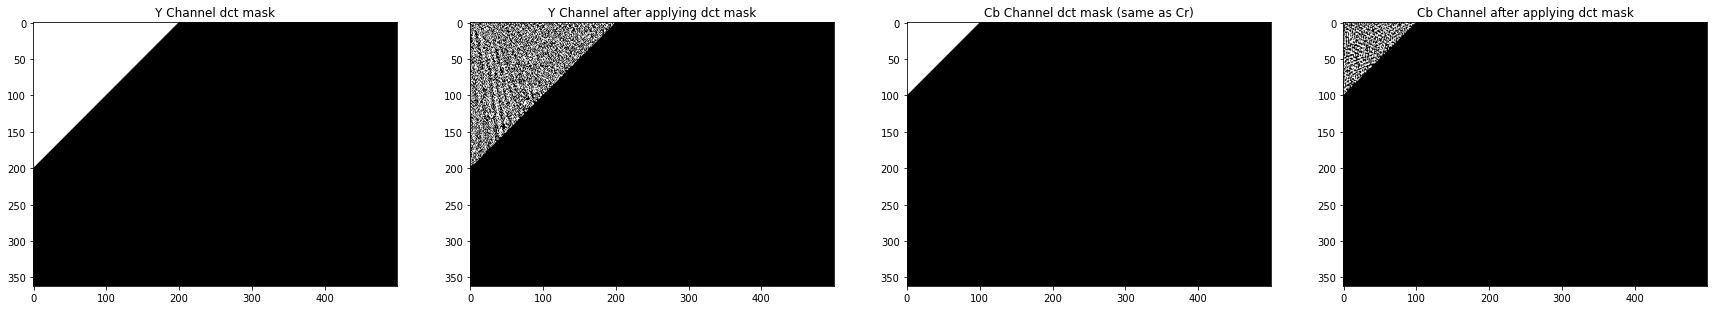

In [17]:
f, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(30, 20))

ax0.imshow(maskYdct,cmap='gray')
ax0.set_title('Y Channel dct mask', fontsize=12)

ax1.imshow((np.log10( Y_dct_mask)).astype(int), cmap=pylab.cm.gray)
ax1.set_title('Y Channel after applying dct mask', fontsize=12)

ax2.imshow(maskCbdct,cmap='gray')
ax2.set_title('Cb Channel dct mask (same as Cr)', fontsize=12)

ax3.imshow((np.log10(Cb_dct_mask)).astype(int), cmap=pylab.cm.gray)
ax3.set_title('Cb Channel after applying dct mask', fontsize=12)

#### β) Εφαρμογή μάσκας για αποκοπή λιγότερων σημαντικών στοιχείων του DCT (σε block 8x8 την εικόνα) Χρήση 3 μασκών
> Άσκηση 2:
Να εφαρμοστούν οι μάσκες κβάντισης καθώς και η zigzag  στο DCT 8x8 block της εικόνας

In [18]:
#Zigzag μάσκας για block 8x8
maskzigzagY=zigzag(35)
maskzigzagCb=zigzag(20)
maskzigzagCr=zigzag(20)

maskblkzigzagY = cv2.filter2D(Y_dct_blk,-1,maskzigzagY)
maskblkzigzagCb = cv2.filter2D(Cb_dct_blk,-1,maskzigzagCb)
maskblkzigzagCr = cv2.filter2D(Cr_dct_blk,-1,maskzigzagCr)


Text(0.5, 1.0, 'Cr Channel after applying mask')

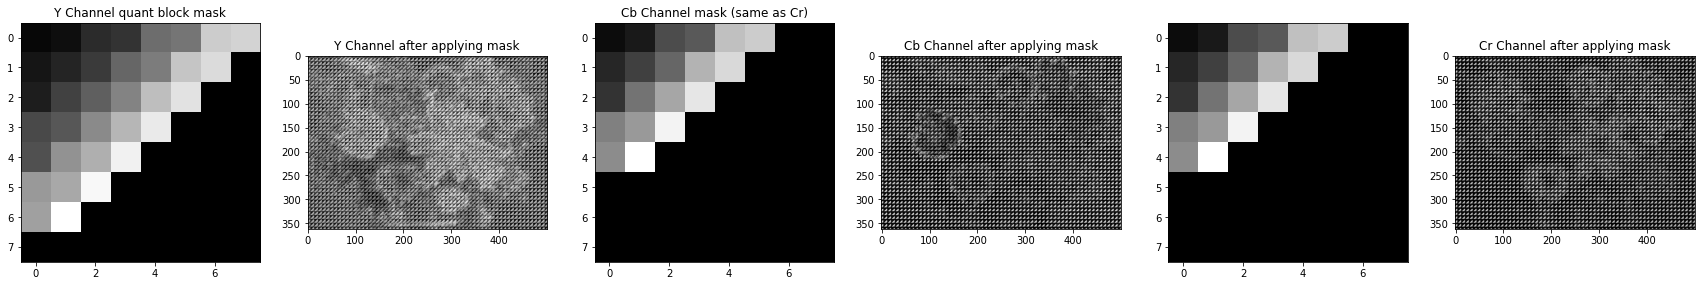

In [19]:
f, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(30, 20))

ax0.imshow(maskzigzagY,cmap='gray')
ax0.set_title('Y Channel quant block mask', fontsize=12)

ax1.imshow(np.log10(1+abs(maskblkzigzagY)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(maskzigzagCb,cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(maskblkzigzagCb)),cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

ax4.imshow(maskzigzagCr,cmap='gray')
ax5.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax5.imshow(np.log10(1+abs(maskblkzigzagCr)), cmap='gray')
ax5.set_title('Cr Channel after applying mask', fontsize=12)



In [20]:
# q:  Quality 
q=9
maskYquant=1/mask_quant_Y(q)
maskCquant=1/mask_quant_C(q)

maskblkQuantY = cv2.filter2D(Y_dct_blk,-1,maskYquant)
maskblkQuantCb = cv2.filter2D(Cb_dct_blk,-1,maskCquant)
maskblkQuantCr = cv2.filter2D(Cr_dct_blk,-1,maskCquant)



Text(0.5, 1.0, 'Cr Channel after applying mask')

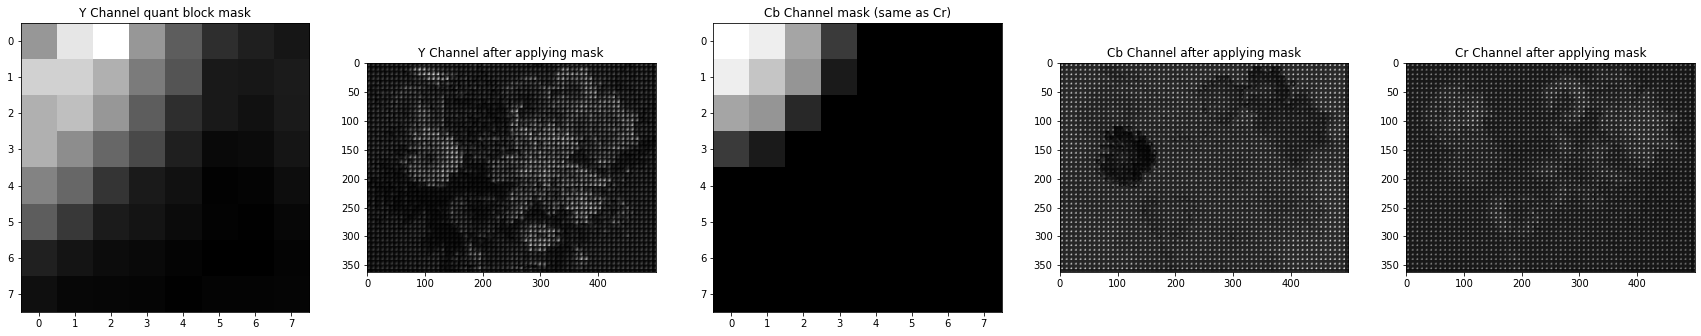

In [21]:
f, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(30, 20))

ax0.imshow(maskYquant,cmap='gray')
ax0.set_title('Y Channel quant block mask', fontsize=12)

ax1.imshow(np.log10(1+abs(maskblkQuantY)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(maskCquant,cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(maskblkQuantCb)),cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

ax4.imshow(np.log10(1+abs(maskblkQuantCr)), cmap='gray')
ax4.set_title('Cr Channel after applying mask', fontsize=12)

##Βήμα 3: Αποκωδικοποίηση εικόνας
> Άσκηση 3:
Να εφαρμοστούν οι αντίστροφοι μετασχηματισμοί για όλες τις περιπτώσεις 


####Αντίστροφος μετασχηματισμό DCT για την εικόνα που εφαρμόσαμε συμπίεση με μάσκα για DCT ίδιου μεγέθους με τη αρχική εικόνα

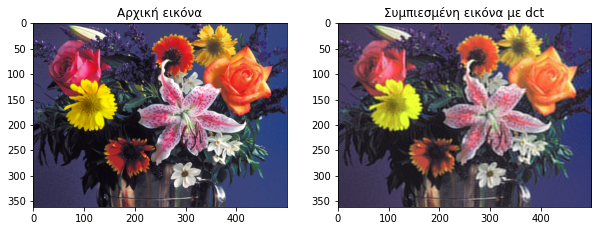

In [22]:
idctYCbCr=np.zeros(image.shape) #initial image size
idctYCbCr[:,:,0]=abs(idct2(Y_dct_mask))
idctYCbCr[:,:,1]=abs(idct2(Cb_dct_mask))
idctYCbCr[:,:,2]=abs(idct2(Cr_dct_mask))

idctYCbCr = idctYCbCr.astype('float32')

idctRGB = cv2.cvtColor(idctYCbCr, cv2.COLOR_YCrCb2BGR)

#Απεικόνιση και αποθήκευση της συμπιεσμένης εικόνας
imshow_all(image,idctRGB, titles= ['Αρχική εικόνα','Συμπιεσμένη εικόνα με dct'])
io.imsave('dctcompressed.bmp', idctRGB)

#### Αντίστροφος μετασχηματισμός DCT

####Αντίστροφος μετασχηματισμό DCT για την εικόνα που εφαρμόσαμε συμπίεση με μάσκα zigzag σε DcT block

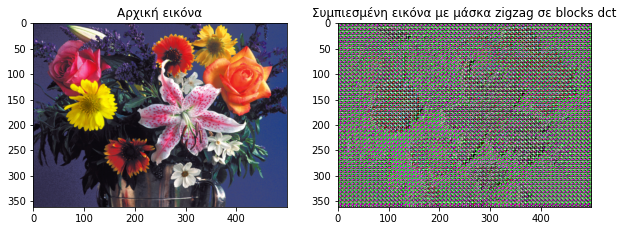

In [23]:
im_iblkdct = np.zeros(image.shape)

im_iblkdct[:,:,0]=idct2block(maskblkzigzagY)
im_iblkdct[:,:,1]=idct2block(maskblkzigzagCb)
im_iblkdct[:,:,2]=idct2block(maskblkzigzagCr)

im_iblkdct = im_iblkdct.astype('float32')
iblkzigzagRGB = cv2.cvtColor(im_iblkdct, cv2.COLOR_YCrCb2BGR)

#iblkzigzagRGB = np.real(iblkzigzagRGB)

#Απεικόνιση και αποθήκευση της συμπιεσμένης εικόνας
imshow_all(image,iblkzigzagRGB, titles= ['Αρχική εικόνα','Συμπιεσμένη εικόνα με μάσκα zigzag σε blocks dct'])
io.imsave('blkdct.bmp', iblkzigzagRGB)

####Αντίστροφος μετασχηματισμό DCT για την εικόνα που εφαρμόσαμε συμπίεση με μάσκα Quant σε DcT block

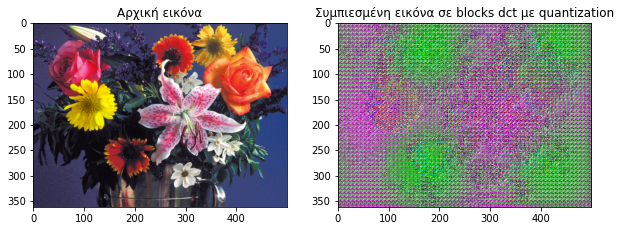

In [24]:
im_blkQidct = np.zeros(image.shape)

maskblkQuantY = cv2.filter2D(Y_dct_blk,-1,mask_quant_Y(q))
maskblkQuantCb = cv2.filter2D(Cb_dct_blk,-1,mask_quant_C(q))
maskblkQuantCr = cv2.filter2D(Cr_dct_blk,-1,mask_quant_C(q))

im_blkQidct[:,:,0]=idct2block(maskblkQuantY)
im_blkQidct[:,:,1]=idct2block(maskblkQuantCb)
im_blkQidct[:,:,2]=idct2block(maskblkQuantCr)

im_blkQidct = im_blkQidct.astype('float32')
iblkQuantRGB = cv2.cvtColor(im_blkQidct, cv2.COLOR_YCrCb2BGR)
iblkQuantRGB =iblkQuantRGB.astype('float32')

#Απεικόνιση και αποθήκευση της συμπιεσμένης εικόνας
imshow_all(image,iblkQuantRGB, titles= ['Αρχική εικόνα','Συμπιεσμένη εικόνα σε blocks dct με quantization'])
io.imsave('blkdctQuant.bmp', iblkQuantRGB)

>Άσκηση 4: Να υπολογιστούν τα SNR & CR για όλους τους μετασχηματισμούς

#### Υπολογισμός λόγου συμπίεσης
Tο PSNR ορίζεται πιο εύκολα μέσω του μέσου τετραγώνου σφάλματος (MSE). Δεδομένης της εικόνας Ι (m × n) χωρίς θόρυβο και της θορυβώδους προσέγγισής της Ι' το MSE ορίζεται ως:

$$MSE=\frac{1}{m,n}\sum _{i=0}^{m-1}\sum _{j=0}^{n-1}[I(i,j)-Ι'(i,j)]^{2}$$

To PSNR (σε dB) ορίζεται ως
$$PSNR=10 \cdot log_{10}\frac{MAX_I^2}{MSE}=20 \cdot log_{10}\frac{MAX_I}{\sqrt{MSE}}=20 \cdot log_{10}{MAX_I}-10\cdot log_{10}{MSE}$$

In [25]:
def psnr(original, compressed):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR


In [26]:
    snrdct=compute_psnr(idctRGB,image)
    snrZizZag=compute_psnr(iblkzigzagRGB,image)
    snrQuant=compute_psnr(iblkQuantRGB,image)
    
    print('SNR DCT σε ολόκληρη την εικόνα:',snrdct)
    print('SNR DCT με zigzag block την εικόνα:',snrZizZag)
    print('SNR DCT quantization:',snrQuant)
  

NameError: ignored

$$Compression Ration=CR=\frac{SIZE_{UncompressedImage}}{SIZE_{CompressedImage}}$$

*Παράδειγμα*
> Έστω η Original Image έχει μέγεθος (256x256)pixels x 8 bits per pixel τότε θα είναι:
 $SIZE_{UncompressedImage}$= 65536 bytes

 >Έστω μια συμπίεση της Original Image έχει μέγεθος  $SIZE_{CompressedImage}$= 6554 bytes

 τότε το $CR$=9,999=10 ή $CR$ 10:1


##Bits per pixels

Για μία εικόνα MxM έχουμε:
$$\frac{bits}{pixels}=\frac{N_{bits}}{N_{pixels}}=\frac{8(N_{bytes})}{MxM}$$

In [ ]:
CRdct = sum(sum((Y_dct_mask != 0) + (Cb_dct_mask != 0) + (Cr_dct_mask != 0))) / (image.shape[0]*image.shape[1]*image.shape[2]);

print('Compression Ration μετά από συμπίεση με DCT σε ολόκληρη την εικόνα:',CRdct)

# Jpeg Συμπίεση (JPEG: Joint Photographic Experts Group)
> ![Σχήμα 1](https://drive.google.com/uc?id=1fj0PWtU-tKHUjDfd8bIgwuz6uaa9yBPk)

#### 1.	Μετατροπή χρωματικού χώρου : από RGB σε YCbCr. 
  Κανάλι Y : φωτεινότητα των pixel, 

  Κανάλια Cb,Cr : χρωματικές συνιστώσες
  
  YCbCr : digital color television 

> Επιτρέπει μεγάλη συμπίεση χωρίς σημαντική οπτική επίδραση στην ποιότητα της εικόνας,

> Μεγαλύτερη συμπίεση μπορεί να πραγματοποιηθεί στα κανάλια Cb, Cr χωρίς να είναι εμφανής από το ανθρώπινο οπτικό σύστημα. 

####2.	Εφαρμογή μετασχηματισμού 2D-DCT
####3.	Κβαντισμός 
Το μάτι έχει διαφορετική ευαισθησία και διακριτική ικανότητα όσον αφορά στις χωρικές μεταβολές της φωτεινότητας (χωρικές συχνότητες):

>Οι πίνακες κβαντισμού αντιπροσωπεύουν την ευαισθησία αυτή

>Όσο μικρότερος είναι ο αντίστοιχος συντελεστής στον πίνακα κβαντισμού τόσο μεγαλύτερη θεωρείται η διακριτική ικανότητα του ματιού στη συγκεκριμένη συχνότητα
> ![Σχήμα 2](https://drive.google.com/uc?id=1nJoYG3Oo4pJkOxy3ix8SK1Nycv1_Hx9V)

####4.	Κωδικοποίηση

>	Διανυσματοποίηση του μπλοκ από τους κβαντισμένους συντελεστές με zig-zag scanning 

>	Διαφορική κωδικοποίηση των συντελεστών DC γειτονικών μπλοκ

>	Κωδικοποίηση μήκους διαδρομής για τους AC συντελεστές κάθε μπλοκ

>	Huffman coding επί των συμβόλων που προέκυψαν από τη διαφορική κωδικοποίηση και την κωδικοποίηση μήκους διαδρομής 

####5.	Δημιουργία JPEG frame 
> Προσθήκη ένδειξης αρχής και τέλους frame

> Επικεφαλίδες (χρωματικά κανάλια, διαστάσεις εικόνας,κλπ)

> Περιεχόμενα εικόνας (πολυπλεξία μπλοκ από διαφορετικά χρωματικά κανάλια ώστε να επιτυγχάνεται σταδιακή αποκωδικοποίηση)

>Δεδομένα των μπλοκ 

[JPEG Image Compression Systems](https://www.ece.ucdavis.edu/cerl/reliablejpeg/compression/)


